
Training StandardMLP


 20%|██        | 1/5 [00:16<01:05, 16.38s/it]

StandardMLP Epoch 1/5, Train Loss: 0.2170, Test Accuracy: 96.37%


 40%|████      | 2/5 [00:33<00:49, 16.53s/it]

StandardMLP Epoch 2/5, Train Loss: 0.0899, Test Accuracy: 97.21%


 60%|██████    | 3/5 [00:49<00:33, 16.53s/it]

StandardMLP Epoch 3/5, Train Loss: 0.0645, Test Accuracy: 97.42%


 80%|████████  | 4/5 [01:06<00:16, 16.51s/it]

StandardMLP Epoch 4/5, Train Loss: 0.0492, Test Accuracy: 97.67%


100%|██████████| 5/5 [01:23<00:00, 16.64s/it]


StandardMLP Epoch 5/5, Train Loss: 0.0385, Test Accuracy: 97.56%

Training SymmetricMLP


 20%|██        | 1/5 [00:19<01:17, 19.46s/it]

SymmetricMLP Epoch 1/5, Train Loss: 0.2246, Test Accuracy: 95.83%


 40%|████      | 2/5 [00:38<00:58, 19.45s/it]

SymmetricMLP Epoch 2/5, Train Loss: 0.1209, Test Accuracy: 96.21%


 60%|██████    | 3/5 [00:58<00:38, 19.42s/it]

SymmetricMLP Epoch 3/5, Train Loss: 0.0973, Test Accuracy: 96.41%


 80%|████████  | 4/5 [01:17<00:19, 19.40s/it]

SymmetricMLP Epoch 4/5, Train Loss: 0.0843, Test Accuracy: 95.90%


100%|██████████| 5/5 [01:37<00:00, 19.40s/it]


SymmetricMLP Epoch 5/5, Train Loss: 0.0721, Test Accuracy: 96.54%

Training HorizontalMirroredMLP


 20%|██        | 1/5 [00:19<01:18, 19.60s/it]

HorizontalMirroredMLP Epoch 1/5, Train Loss: 603.5231, Test Accuracy: 76.35%


 40%|████      | 2/5 [00:39<00:58, 19.62s/it]

HorizontalMirroredMLP Epoch 2/5, Train Loss: 180.8713, Test Accuracy: 80.21%


 60%|██████    | 3/5 [00:58<00:39, 19.62s/it]

HorizontalMirroredMLP Epoch 3/5, Train Loss: 117.5194, Test Accuracy: 82.61%


 80%|████████  | 4/5 [01:18<00:19, 19.66s/it]

HorizontalMirroredMLP Epoch 4/5, Train Loss: 86.0923, Test Accuracy: 83.74%


100%|██████████| 5/5 [01:38<00:00, 19.66s/it]


HorizontalMirroredMLP Epoch 5/5, Train Loss: 67.0689, Test Accuracy: 85.14%

Training VerticalMirroredMLP


 20%|██        | 1/5 [00:19<01:18, 19.65s/it]

VerticalMirroredMLP Epoch 1/5, Train Loss: 339.4361, Test Accuracy: 44.81%


 40%|████      | 2/5 [00:39<00:58, 19.65s/it]

VerticalMirroredMLP Epoch 2/5, Train Loss: 91.9600, Test Accuracy: 46.09%


 60%|██████    | 3/5 [00:58<00:39, 19.66s/it]

VerticalMirroredMLP Epoch 3/5, Train Loss: 56.2559, Test Accuracy: 47.40%


 80%|████████  | 4/5 [01:18<00:19, 19.67s/it]

VerticalMirroredMLP Epoch 4/5, Train Loss: 39.3681, Test Accuracy: 47.46%


100%|██████████| 5/5 [01:38<00:00, 19.65s/it]

VerticalMirroredMLP Epoch 5/5, Train Loss: 28.3634, Test Accuracy: 47.64%


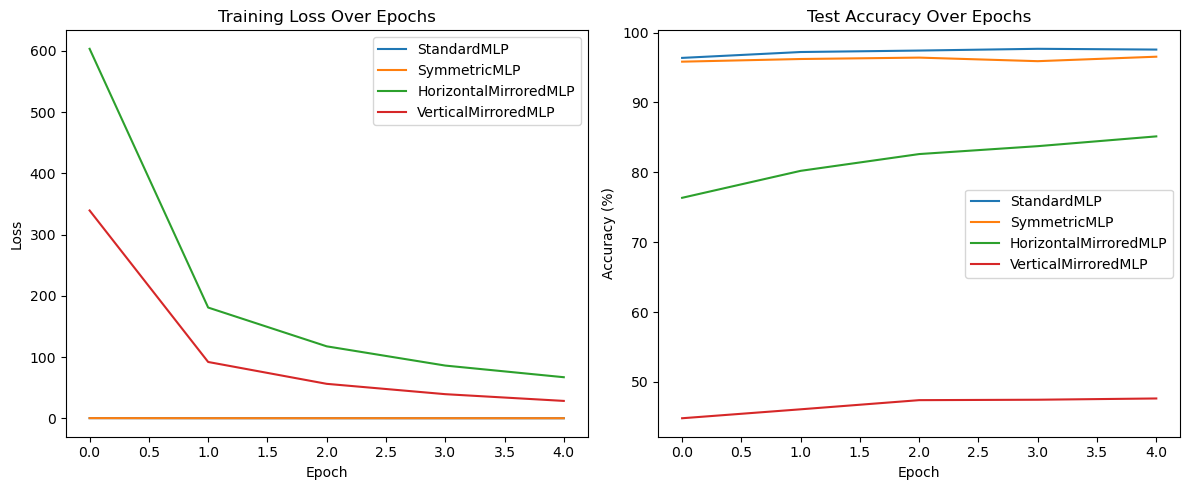


Computing loss landscape for StandardMLP


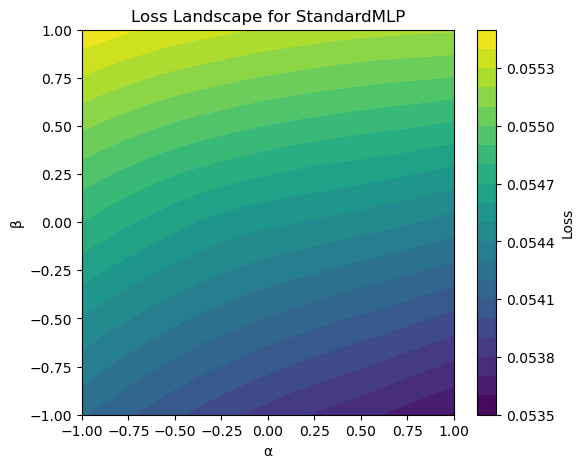


Computing loss landscape for SymmetricMLP


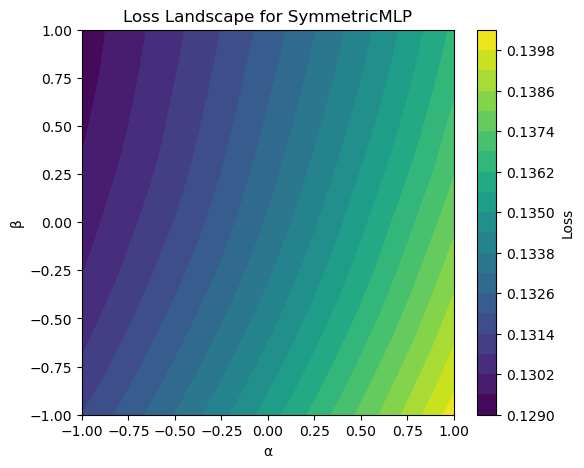


Computing loss landscape for HorizontalMirroredMLP


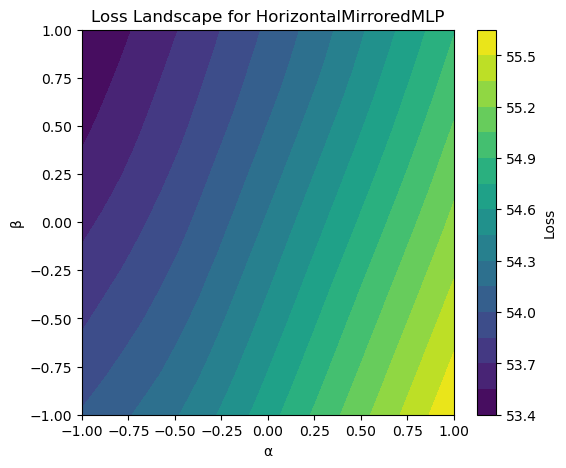


Computing loss landscape for VerticalMirroredMLP


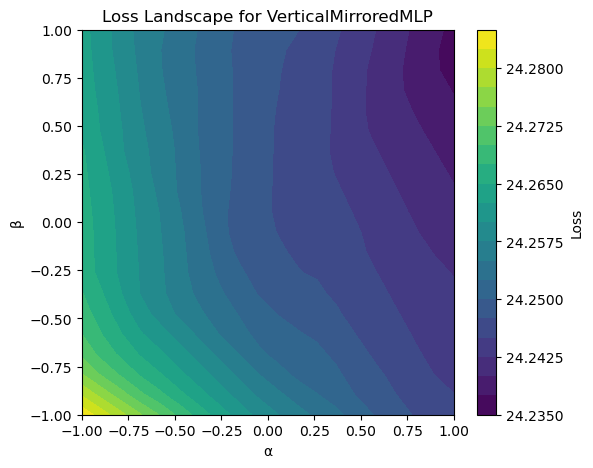

In [7]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define transformations for MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # Mean and std for MNIST
])

# Load MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

# Subset for loss landscape computation (to reduce computation time)
subset = Subset(train_dataset, range(1000))
subset_loader = DataLoader(subset, batch_size=64, shuffle=False)

# Define custom linear layers
class SymmetricLinear(nn.Module):
    """Linear layer with symmetric weight matrix (W = W^T)"""
    def __init__(self, size):
        super(SymmetricLinear, self).__init__()
        self.size = size
        self.U = nn.Parameter(torch.randn(size, size))  # Parameter matrix
        self.bias = nn.Parameter(torch.zeros(size))

    def forward(self, x):
        W = (self.U + self.U.t()) / 2  # Enforce symmetry
        return F.linear(x, W, self.bias)

class HorizontalMirroredLinear(nn.Module):
    """Linear layer with weights mirrored along horizontal axis"""
    def __init__(self, in_features, out_features):
        super(HorizontalMirroredLinear, self).__init__()
        assert in_features % 2 == 0, "in_features must be even"
        self.in_features = in_features
        self.out_features = out_features
        self.U = nn.Parameter(torch.randn(in_features // 2, out_features))
        self.bias = nn.Parameter(torch.zeros(out_features))

    def forward(self, x):
        W = torch.cat([self.U, self.U.flip(0)], dim=0)  # Mirror horizontally
        return F.linear(x, W.T, self.bias)

class VerticalMirroredLinear(nn.Module):
    """Linear layer with weights mirrored along vertical axis"""
    def __init__(self, in_features, out_features):
        super(VerticalMirroredLinear, self).__init__()
        assert out_features % 2 == 0, "out_features must be even"
        self.in_features = in_features
        self.out_features = out_features
        self.U = nn.Parameter(torch.randn(in_features, out_features // 2))
        self.bias = nn.Parameter(torch.zeros(out_features))

    def forward(self, x):
        W = torch.cat([self.U, self.U.flip(1)], dim=1)  # Mirror vertically
        return F.linear(x, W.T, self.bias)

# Define the four MLP models
class StandardMLP(nn.Module):
    def __init__(self):
        super(StandardMLP, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class SymmetricMLP(nn.Module):
    def __init__(self):
        super(SymmetricMLP, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = SymmetricLinear(256)  # Symmetric weight matrix between hidden layers
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class HorizontalMirroredMLP(nn.Module):
    def __init__(self):
        super(HorizontalMirroredMLP, self).__init__()
        self.fc1 = HorizontalMirroredLinear(784, 256)
        self.fc2 = HorizontalMirroredLinear(256, 256)
        self.fc3 = HorizontalMirroredLinear(256, 10)

    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class VerticalMirroredMLP(nn.Module):
    def __init__(self):
        super(VerticalMirroredMLP, self).__init__()
        self.fc1 = VerticalMirroredLinear(784, 256)
        self.fc2 = VerticalMirroredLinear(256, 256)
        self.fc3 = VerticalMirroredLinear(256, 10)

    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Training function
def train(model, train_loader, test_loader, epochs=20):
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    
    train_losses = []
    test_accuracies = []
    
    for epoch in tqdm(range(epochs)):
        model.train()
        running_loss = 0.0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        
        # Evaluate on test set
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                _, predicted = torch.max(output.data, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
        test_accuracy = 100 * correct / total
        test_accuracies.append(test_accuracy)
        
        print(f'{model.__class__.__name__} Epoch {epoch+1}/{epochs}, '
              f'Train Loss: {train_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')
    
    return train_losses, test_accuracies

# Function to compute and plot loss landscape
def compute_loss_landscape(model, loader, grid_size=20, margin=1.0):
    from torch.nn.utils import parameters_to_vector, vector_to_parameters
    model.eval()
    theta_star = parameters_to_vector(model.parameters()).detach()
    
    # Generate two orthogonal random directions
    d1 = torch.randn_like(theta_star)
    d1 /= torch.norm(d1)
    d2 = torch.randn_like(theta_star)
    d2 -= (d1 * d2).sum() * d1 / (d1 * d1).sum()  # Orthogonalize
    d2 /= torch.norm(d2)
    
    alpha = torch.linspace(-margin, margin, grid_size)
    beta = torch.linspace(-margin, margin, grid_size)
    losses = torch.zeros(grid_size, grid_size)
    
    criterion = nn.CrossEntropyLoss()
    
    for i, a in enumerate(alpha):
        for j, b in enumerate(beta):
            theta = theta_star + a * d1 + b * d2
            vector_to_parameters(theta, model.parameters())
            running_loss = 0.0
            batch_count = 0
            for data, target in loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)
                running_loss += loss.item()
                batch_count += 1
                if batch_count >= 10:  # Limit to 10 batches
                    break
            losses[i, j] = running_loss / batch_count
    
    plt.figure(figsize=(6, 5))
    plt.contourf(alpha.numpy(), beta.numpy(), losses.numpy(), levels=20)
    plt.colorbar(label='Loss')
    plt.title(f'Loss Landscape for {model.__class__.__name__}')
    plt.xlabel('α')
    plt.ylabel('β')
    plt.show()

# Train all models
models = {
    'StandardMLP': StandardMLP(),
    'SymmetricMLP': SymmetricMLP(),
    'HorizontalMirroredMLP': HorizontalMirroredMLP(),
    'VerticalMirroredMLP': VerticalMirroredMLP()
}

train_losses = {}
test_accuracies = {}

epochs = 5

for name, model in models.items():
    print(f'\nTraining {name}')
    train_losses[name], test_accuracies[name] = train(model, train_loader, test_loader, epochs=epochs)

# Plot training losses and test accuracies
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
for name in models:
    plt.plot(train_losses[name], label=name)
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
for name in models:
    plt.plot(test_accuracies[name], label=name)
plt.title('Test Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

# Compute and plot loss landscapes for each model
for name, model in models.items():
    print(f'\nComputing loss landscape for {name}')
    compute_loss_landscape(model, subset_loader)